# Plot the time against velocity of points

In [1]:
import numpy as np

from IPython.display import display
from PIL import Image
from peewee import IntegerField, Model, CharField, SqliteDatabase, AutoField
import matplotlib.pyplot as plt

db = SqliteDatabase('events-testing-after-fix.db')


class Events(Model):
    id = AutoField()
    time = IntegerField()
    agent = CharField()
    event = CharField()
    participant_id = IntegerField()
    old_value = CharField(null=True)
    new_value = CharField(null=True)
    screenshot_file = CharField(null=True)

    class Meta:
        database = db

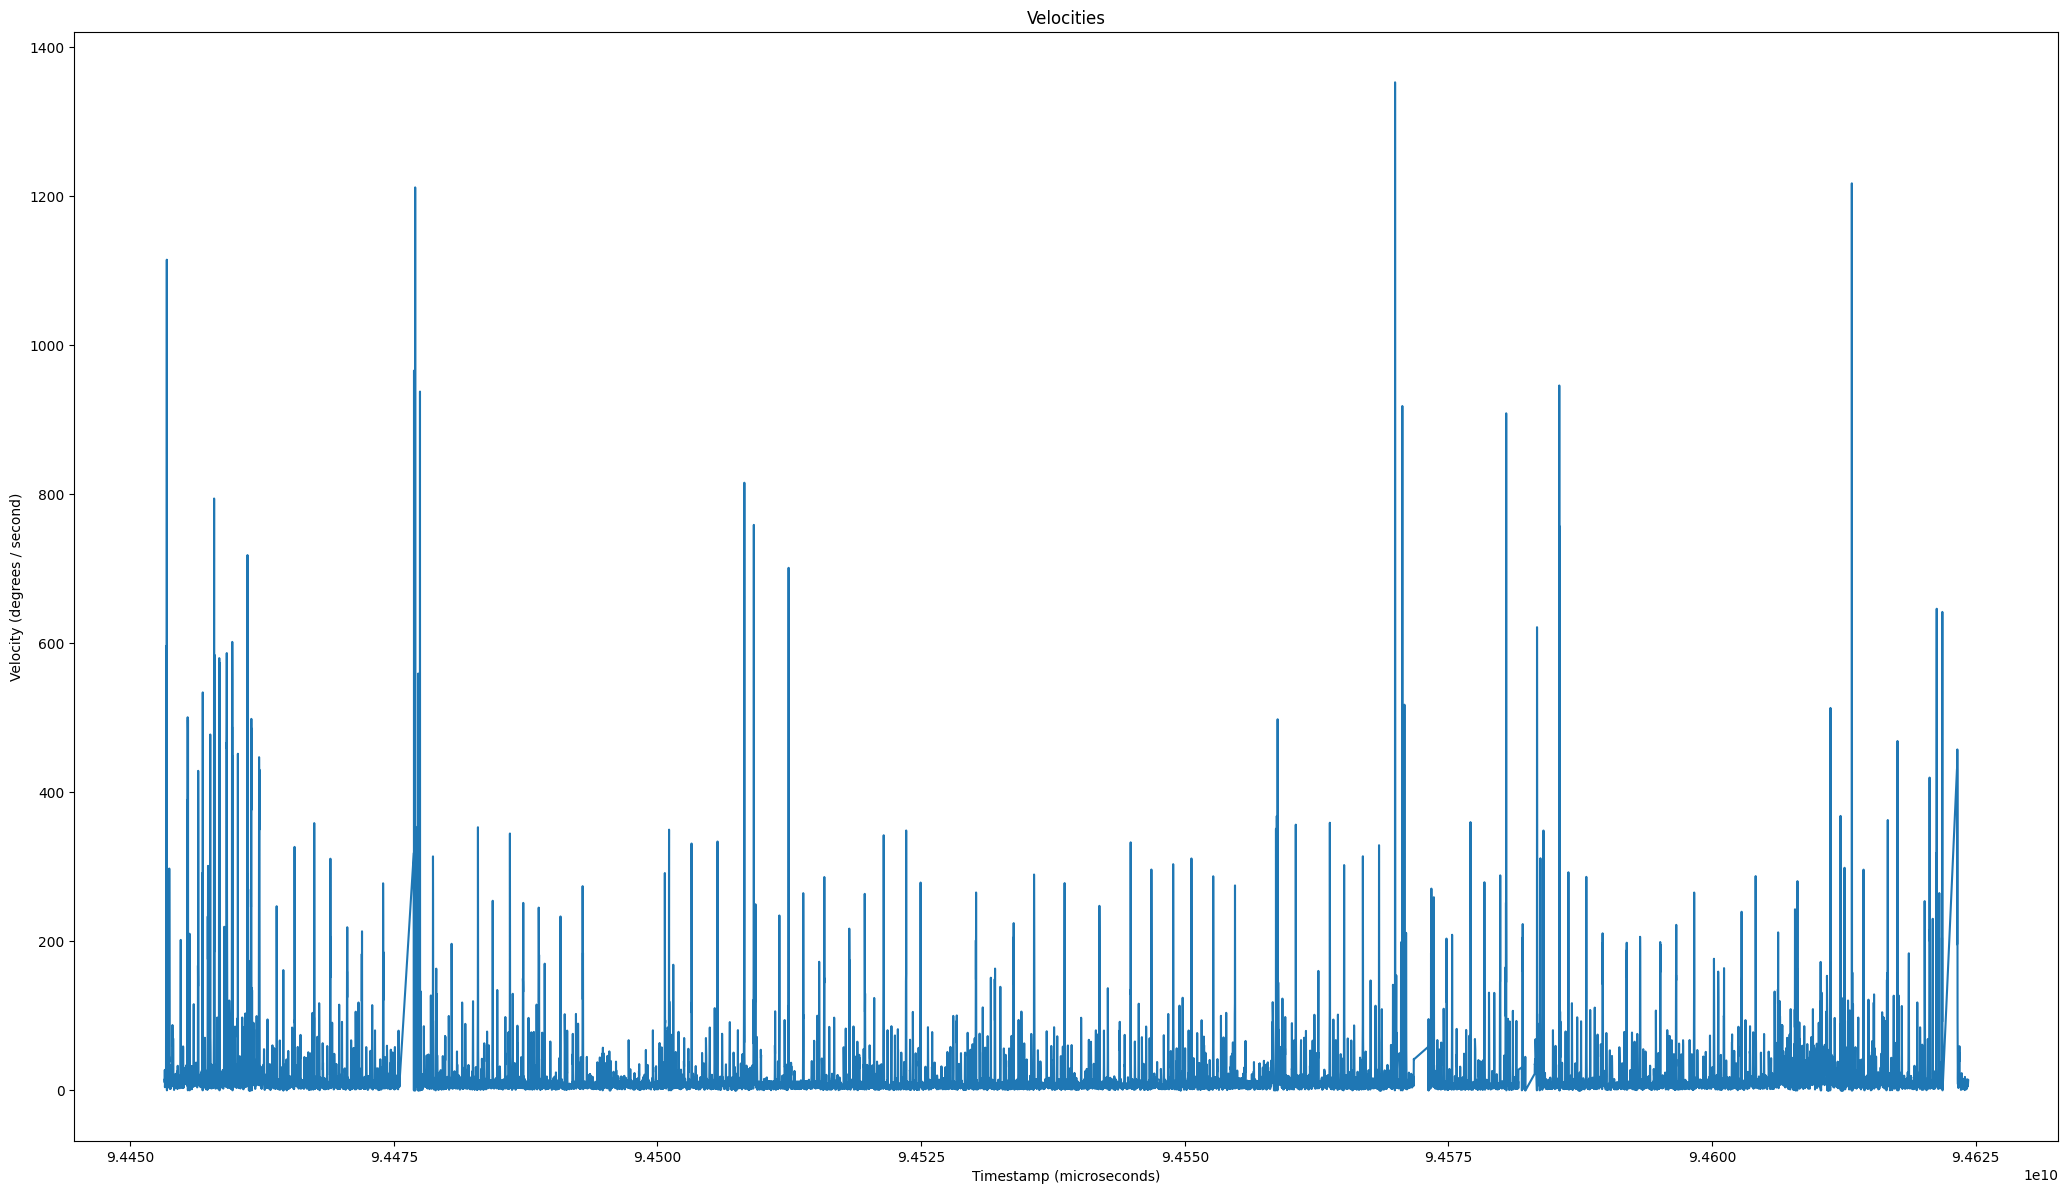

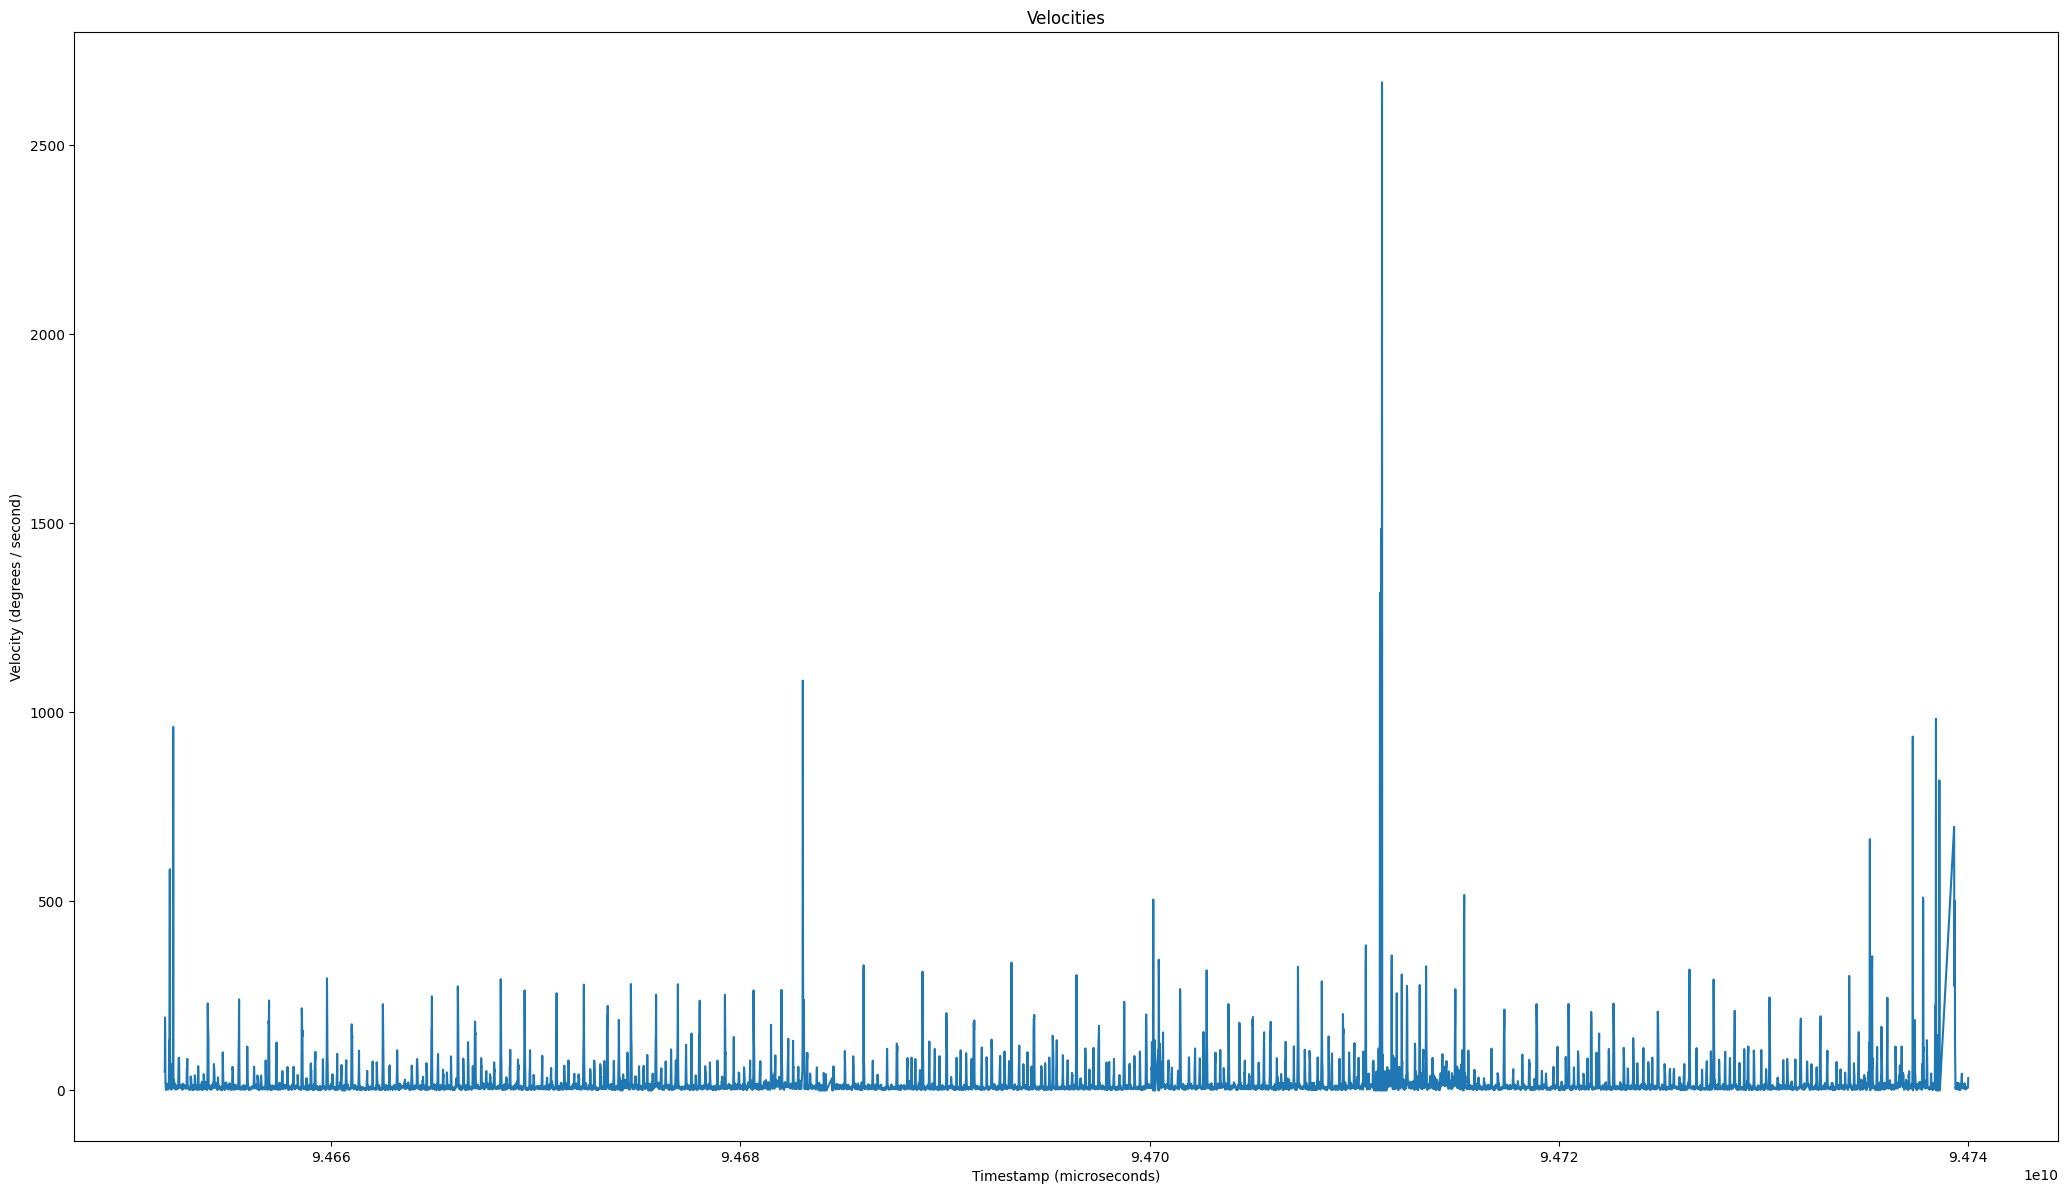

In [2]:
import os
from datetime import datetime
from utils import X_PIXELS, Y_PIXELS, DEGREES_PER_PIXEL


# participants that were told that they can change the settings beforehand
participant_ids = [998]

# get the events 
for participant in participant_ids:
  events = Events.select().where(Events.participant_id==participant)
  
  current_json_file = None
  batches_of_events = {}
  current_batch = []
  for event in events:
    if event.event == "SELECT_TREATMENT":
      continue
    elif event.event == "CLOSE_BOOK":
      current_batch.append(event)
      batches_of_events[current_json_file] = current_batch
      current_batch = []
    elif event.event == "OPEN_BOOK":
      timestamp = event.time
      date = datetime.fromtimestamp(timestamp / 1000)
      date_string = date.strftime("%Y-%m-%d_%H-%M-%S")
      current_json_file = f"[{participant}]-{date_string}.json"
      current_batch.append(event)
    else:
      current_batch.append(event)

  # for each json file, get the gaze data
  for json_file, events in batches_of_events.items():
    # get the gaze data for this participant
    # the files are in eye_tracker_data/
    path = "eye_tracker_data/"

    # for start_event in events:
    gaze_data_filename = json_file
    gaze_data_filepath = os.path.join(path, gaze_data_filename)
    # Read the file
    import json
    with open(gaze_data_filepath, "r") as f:
      gaze_data = json.load(f)

    gaze_data = gaze_data["data"]

    timestamps = []
    velocities = []
    for a, b in zip(gaze_data, gaze_data[1:]):
      if a["right_gaze_point_validity"] == 0 or b["right_gaze_point_validity"] == 0:
        continue

      delta_x = (b["right_gaze_point_on_display_area"][0] - a["right_gaze_point_on_display_area"][0]) * X_PIXELS
      delta_y = (b["right_gaze_point_on_display_area"][1] - a["right_gaze_point_on_display_area"][1]) * Y_PIXELS

      distance = np.sqrt(delta_x ** 2 + delta_y ** 2) * DEGREES_PER_PIXEL

      velocity =  distance / (b["system_time_stamp"] - a["system_time_stamp"]) * 1_000_000

      timestamps.append(b["system_time_stamp"])
      velocities.append(velocity)


    # plot the velocities
    fig, ax = plt.subplots(figsize=(X_PIXELS / 100, Y_PIXELS / 100))
    ax.plot(timestamps, velocities)
    plt.title("Velocities")
    plt.xlabel("Timestamp (microseconds)")
    plt.ylabel("Velocity (degrees / second)")
    plt.show()

